## User Example

This notebook outlines the steps needed to use Syndat to generate a set of reduced experimental Transmission data for evaluating total neutron cross sections.

The primary user controls of interest are likely:
- energy grid structure
- total noise amount
- the spin groups to be considered
- the average parameter values for each of the spin groups

These can all be controlled within this script. Just few sections down you can define the **energy grid, spin groups, and average parameters**. The **noise level** is controlled later in the section titles "Run the experiment and Analyze"


In [3]:
import numpy as np
import syndat
import pandas as pd
import os
from matplotlib.pyplot import *


In [4]:
%matplotlib widget

### Define the particle-pair of interest

The particle pair class in syndat characterizes the reaction taking place. 

The method "map_quantum_numbers" will calculate (and print if print_out=True) the open reaction channels for given a maximum number of orbital angular momenta to consider. This can be used to visualize the spin groups that may be present in a cross section.

In [5]:
ac = 0.81271    # scattering radius in 1e-12 cm 
M = 180.948030  # amu of target nucleus
m = 1           # amu of incident neutron
I = 3.5         # intrinsic spin, positive parity
i = 0.5         # intrinsic spin, positive parity
l_max = 1       # highest order l-wave to consider

Ta_pair = syndat.particle_pair(ac, M, m, I, i, l_max)

Ta_pair.map_quantum_numbers(True)


The following arrays describe all possible spin groups for a each parity.
    The data is given as a tuple where the first value is the integer 
    or half integer total quantum spin J and the second value is the 
    number of entrance channels for that spin group. 
    * See the dictionary "possible_Jpi" for a nested packing structure.

Spin group data for all parity
(Jpi, #Chs, l-waves)
(-5.0, 1, [1.0])
(-4.0, 2, [1.0, 1.0])
(-3.0, 2, [1.0, 1.0])
(-2.0, 1, [1.0])
(3.0, 1, [0.0])
(4.0, 1, [0.0])


## Define an energy grid and average resonance parameters

Here the user defines the primary parameters for the cross section they want to use. This includes:
- energy grid structure
- spin groups
- average parameter values for those spin groups

The spin group data can be re-defined to focus on a specific set of spin groups, or the "J" attribute of the particle_pair defined above can be used directly if you want to include all spin groups up to a given order of waveform.

* Note:
    The noise level is controlled with the trig parameter which is analogous to the time of measurment (more time better statistics). This is an input to the experiment class and can be edited a few code sections below.

To generate an energy grid that is similar to what would be seen in an experiment, you must start with time-of-flight. An experiment produces counts that are linearly spaced in time-of-flight which is related to energy by:

$ KE = \frac{1}{2}mv^2 = \frac{1}{2}m (\frac{FP}{ToF})^2 $ where FP is the distance or flight path and ToF is time of flight. The relativistic form of this equation can be used, however, it does not make m uch difference in this energy regime. 

Generally the resolution is on the order of nanoseconds, however, the experimentalists will increase this bin size, improving the statistics in a given bin at the loss of some resolution. This is a non-mechanistic process that results in a couple of different bin sizes throughout the ToF spectrum. A standard bin size in the RRR for Ta181 with a flight path of 35 m is on the order of 20-100ns

* Note:
    Defining a linear energy grid will result in a wild binning stucture in tof. Consider defining a tof grid instead. In practice, the tof grid has a handful (5 or so) different bin widths and a constant bin width between each point of compresssion. This is due to the artisinal nature of this process, a complicated binning stucture is less justifiable, difficult to store in EXFOR, and requires the use of a complicated resolution broadening function.

In [6]:
# # define energy grid in eV - note that this approach creates a crazy tof bin width structure
# energy_grid = np.linspace(1,100,1000)

# create a linear tof grid
E_min_max = [100, 1000]
tof_min_max = syndat.exp_effects.e_to_t(np.array(E_min_max),35.185, True)
bin_width = 0.1e-6
tof_grid = np.arange(min(tof_min_max), max(tof_min_max), bin_width)
energy_grid = syndat.exp_effects.t_to_e(tof_grid,35.185,True)

In [7]:


# spin_groups variable here is equivalent to Ta_pair.J
# spin_groups = [ (3.0,1,[0]), (4.0,1,[0]), (-4.0,2,[1.0, 1.0])]
spin_groups = [ (3.0,1,[0])]

# an alternative option would be to give Ta_pair.J, as long as you give an average parameter dataframe with corresponding indices
# spin_groups = Ta_pair.J

average_parameters = pd.DataFrame({ 'dE'    :   {'3.0':20.0, '4.0':15.0, '-4.0':15.0},
                                    'Gg'    :   {'3.0':80.0, '4.0':55.0, '-4.0':55.0},
                                    'gn2'    :   {'3.0':50.0, '4.0':10.0, '-4.0':10.0}  })


### Sample a ladder of resonances parameters using Syndat

In [62]:

resonance_ladder = Ta_pair.sample_resonance_ladder(energy_grid, spin_groups, average_parameters)

# # look at your resonance ladder
resonance_ladder

# import json
# resonance_ladder.to_csv('test')
# test = pd.read_csv('test', index_col=0)
# # type(json.loads(test.lwave[0]))
# test = test.lwave.apply(json.loads)
# resonance_ladder['lwave']=test
# type(resonance_ladder.lwave[0])


list

### Calculate a theoretical cross section from the resonance ladder

The theoretical cross section can be calculated using the syndat code. The output total cross section must be converted to a transmission and stored in a dataframe with keys "E" and "theo_trans" before it can be passed to the experiment. The experiment object turns a theoretical cross section to a corresponding set of experimental Transmission data.

Transmission is related to total cross section in the following way:

$T = e^{-n*\sigma_t} $

Where n is the thickness of the target in unites atoms/barn.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0.01, 'Energy (eV)')

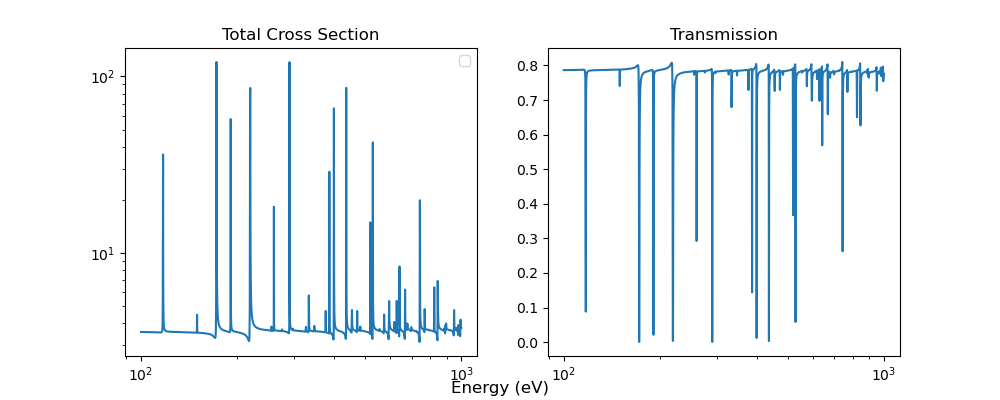

In [63]:
# SLWB with syndat
xs_tot, xs_scat, xs_cap = syndat.scattering_theory.SLBW(energy_grid, Ta_pair, resonance_ladder)

# convert to transmisison and put in an appropriate dataframe
n = 0.067166 # atoms per barn or atoms/(1e-12*cm^2)
trans = np.exp(-n*xs_tot)
theoretical_df = pd.DataFrame({'E':energy_grid, 'theo_trans':trans})

fig, ax = subplots(1,2, figsize=(10,4))
# ax[0].plot(sammy_calculated.E, sammy_calculated.theo_xs, label='sammy')
# ax[0].plot(energy_grid, xs_scat)
# ax[0].plot(energy_grid, xs_cap)
ax[0].plot(energy_grid, xs_tot)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_title('Total Cross Section')
ax[0].legend()

ax[1].plot(theoretical_df.E, theoretical_df.theo_trans)
# ax[1].plot(sammy_calculated.E, sammy_calculated.theo_trans, label='sammy')
ax[1].set_xscale('log')
# ax[1].set_ylim([0,1])
ax[1].set_title('Transmission')

fig.supxlabel('Energy (eV)')

### Run the experiment & Analyze

The Syndat experiment object has a number of methods that generate raw count data from the theoretical cross section through a novel method developed by Walton, et al. The synthesized raw count data is then reduced to get an experimentally noise data set with propagated uncertainty. This is stored in the "trans" attribute of the experiment object.

A set of default experimental parameters is already loaded into the experiment class, however, if the user wants to re-define any this can be done by passing in a new_parameteres dictionary. The format for this is shown below. The example is that of the "trigs" parameter. This corresponds to the number of LINAC triggers the sample in data set was exposed to, which is proportional to the length of the measurement. Therefore, this parameter will control the noise level seen in the data.

The user has the option to input an open count spectra. This is an optional input and if None is given, Syndat will aproximate the open count rate spectra as an exponential. The calculate covaraince option, if set to false, will only calculate the diagonal of the covariance matrix.

In [38]:
options = { 'Perform Experiment':True,
            'Add Noise': True,
            'Calculate Covariance': True}

new_parameters = {'trigs': {'val':18476117,    'unc'   :   0}}

exp = syndat.experiment(theoretical_df, 
                        input_options=options, 
                        experiment_parameters=new_parameters)
                        

In [28]:
# figure()
# errorbar(exp.odat.E, exp.odat.cps, yerr=exp.odat.dcps, 
#                                                 fmt='.', color='b', linewidth=1, markersize=3, capsize=2, label='exp_o')
# plot(exp.odat.E, exp.redpar.val.ko*exp.Bi+exp.redpar.val.b0o, label='bkg_o')

# errorbar(exp.sdat.E, exp.sdat.cps, yerr=exp.sdat.dcps, 
#                                                 fmt='.', color='orange', linewidth=1, markersize=3, capsize=2, label='exp_s')
# plot(exp.sdat.E, exp.redpar.val.ks*exp.Bi+exp.redpar.val.b0s, label='bkg_s')              

# legend()
# xscale('log'); xlabel('Energy (eV)')
# yscale('log'); ylabel('cps')

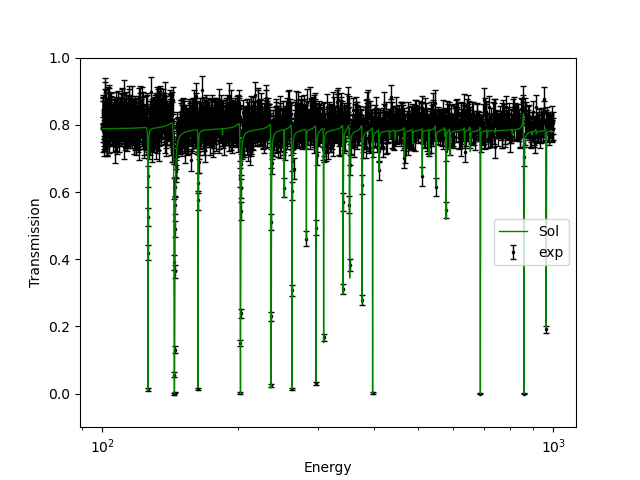

In [39]:
figure()
# plot(exp.trans.E, exp.trans.exp_trans, '.', ms=1, label='exp')
errorbar(exp.trans.E, exp.trans.exp_trans, yerr=exp.trans.exp_trans_unc, zorder=0, 
                                        fmt='.', color='k', linewidth=1, markersize=3, capsize=2, label='exp')

plot(exp.trans.E, exp.trans.theo_trans, color='g', lw=1, label='Sol', zorder=2)

ylim([-.1, 1])
xscale('log')
xlabel('Energy'); ylabel('Transmission')
legend()

### Output in SAMMY format

The data in the experiment object can be accessed directly, or Syndat has a set of utilities to write (and read) SAMMY formatted data files.

In this example, the sammy.dat file will contain the experimental data while the sammy.par file will contain the theoretical parameters from which the data was generated.

In [30]:
syndat.write_samdat(exp.trans,"./test_sammy.dat")
syndat.sammy_interface.write_sampar(resonance_ladder, Ta_pair, False, "./test_sammy.par") #, template="/Users/noahwalton/Documents/GitHub/nuc_syndat/templates/sammy_template_RM_only.par")

## Generating many sets of data

In [31]:
for i in range(3):
    exp2 = syndat.experiment(theoretical_df, 
                        input_options=options, 
                        experiment_parameters=new_parameters)
    # syndat.write_samdat(exp.trans,f"./test_sammy{i}.dat")
    # syndat.sammy_interface.write_sampar(resonance_ladder, Ta_pair, False, f"./test_sammy{i}.par") 
    print(f'{i}: {exp2.trans["theo_trans"].min()} : {exp2.trans["theo_trans"].max()}')
            

0: 4.2923385854757705e-14 : 0.8209677926913589
1: 4.2923385854757705e-14 : 0.8209677926913589
2: 4.2923385854757705e-14 : 0.8209677926913589
